In [173]:
# Import relavant modules
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

C:\Users\hp\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


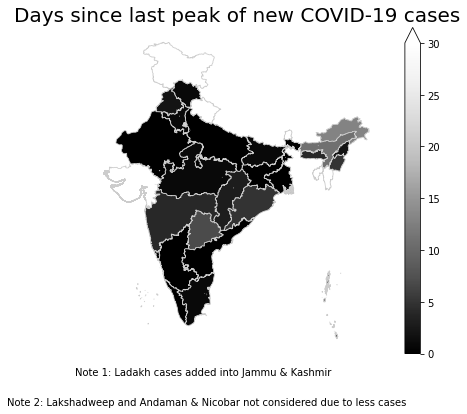

In [273]:
# Read Shape file and store it into map_df
fp = "Indian_States.shp"
map_df = gpd.read_file(fp)
# Read data
df = pd.read_csv('state_wise_daily (1).csv')
# Convert date column into date-time type object
df['Date'] = pd.to_datetime(df['Date'])
# Get confirmed cases only
df_confirmed = df[df['Status']=='Confirmed']
# Dropping total column
df_confirmed.drop(['TT'],axis=1,inplace=True)
# Setting index as date and dropping Status column
df_confirmed = df_confirmed.set_index('Date')
df_confirmed.drop(['Status'],axis=1,inplace=True)

# Get the date at which each state has had maximum
maxes = df_confirmed.idxmax()
# Convert the series into a data frame
maxes = maxes.to_frame()
# Get todays date
latest_date = df_confirmed.index.max()
# remove indexing
maxes = maxes.reset_index()
# Set column names
maxes.columns = ['st_nm','Date']
# Calculate the days since the peak
maxes['Days since peak'] = (latest_date - maxes['Date']).dt.days
# Drop days column
maxes.drop(['Date'],axis=1,inplace=True)
# merge the map and the data
merged = map_df.set_index('st_nm').join(maxes.set_index('st_nm'))
# All above 30 days are brought to 30
merged['Days since peak'] = [30  if x > 30 else x for x in merged['Days since peak']] 

# Create figure
fig, ax = plt.subplots(1, figsize=(8, 6))
# Switch off axis
ax.axis('off')
# Set title
ax.set_title('Days since last peak of new COVID-19 cases', fontdict={'fontsize': '20', 'fontweight' : '3'})
# Craete a plot
ax = merged.plot(column='Days since peak',cmap='Greys_r', linewidth=0.8, ax=ax, edgecolor='0.8')
# Set the color bar and give extend to convey that 30 and 30+ is given as same color
cbar = fig.colorbar(cm.ScalarMappable(norm = plt.Normalize(vmin=0, vmax=30),cmap='Greys_r'), ax=ax,extend = 'max')
# Color bar labelling
cbar.ax.set_yticklabels(['0', '5', '10','15','20','25','30'])
# Text for notes
ax.text(65,3,s = 'Note 1: Ladakh cases added into Jammu & Kashmir')
ax.text(57.5,0,s = 'Note 2: Lakshadweep and Andaman & Nicobar not considered due to less cases')
# Plot and save
plt.show()
fig.savefig("State_wise_greyscale.png", dpi=100)




In [ ]:
# Trying out rolling avergage
states = df_confirmed.columns
for state in states:
    df_confirmed['{}_MA'.format(state)] = df_confirmed[state].rolling(window=7).mean()
    df_confirmed.drop([state],axis = 1,inplace=True) 
maxes['st_nm'] = states

In [ ]:
# Trying out 7 day average
states = df_confirmed.columns
count = 1
for state in states:
    df_confirmed['{}_cumsum'.format(state)] = df_confirmed[state].cumsum()
    df_confirmed['count'] = count
    df_confirmed['{}_avg'.format(state)] = df_confirmed['{}_cumsum'.format(state)]/df_confirmed['count']
    df_confirmed.drop([state,'{}_cumsum'.format(state)],axis = 1,inplace=True)
    count+=1
    
df_confirmed = df_confirmed[df_confirmed['count']//7 == 0 ]
df_confirmed